repeat

# Set up

In [1]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

In [4]:
def filter_rows_by_sum(data, sum_columns, sum_threshold):
    """
    Filters out rows where the sum of specified columns falls below a given threshold.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    - sum_columns (list): List of column names to sum.
    - sum_threshold (float): Minimum sum required to keep the row.

    Returns:
    - pd.DataFrame: Filtered DataFrame containing only rows that meet the sum threshold.
    """
    df = data.copy()
    
    # Ensure all specified columns exist in the DataFrame
    missing_columns = [col for col in sum_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    # Filter rows based on the sum threshold
    filtered_df = df[df[sum_columns].sum(axis=1) < sum_threshold]

    return filtered_df


## read data and define test set

In [5]:
data = pd.read_csv("data/next_step_data.csv")

In [6]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
# n_samples = 1000
# test_data = test_data[:n_samples].copy() ## only take n_samples
test_data = filter_rows_by_sum(test_data, encoding_columns, 2)

## model set up

In [7]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [8]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    print("===== from create_model_data ======")
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    print("data_scores: ", data_scores)
    print("target: ", target)
    return data_scores, target

In [9]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [10]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [11]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_31217/1480764333.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("output/experiment4/model.

# filter out the non-repeats first for ground truth as the base set

In [12]:
import pandas as pd
# find whether it is a repeat domain or not
def assign_repeat(df):
    score_columns = ["domain %d score" %i for i in range(1, 15)]
    encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
    repeat_columns = ["repeat"]
    # print("================= assign_repeat =============")
    # default to false
    df[repeat_columns] = False
    for idx, row in df.iterrows():
        assignment = False
        # print("the row ", row)
        for encoding_col, score_col in zip(encoding_columns, score_columns):
            # print("columns:" , encoding_col, score_col)
            # Find rows where encoding column is 1
            encoding_is_1 = row[encoding_col] == 1
            
            # Check if the corresponding score column is NaN for those rows
            is_nan = not pd.isna(row[score_col])
            # print("encoding is 1 and is nan: ", encoding_is_1, is_nan)
            # Combine the conditions: where encoding column is 1 and score column is NaN
            condition = encoding_is_1 & is_nan
            # print("condition: ", condition)
            if condition:
                assignment = True
                break
            # print("assignment: ", assignment)
        # Set the 'repeat' column to True where the condition is met, False otherwise
        # print("assignment: ", assignment)
        df.loc[idx, 'repeat'] = assignment
        # if not assignment:
        #     print("assigned repeat to False for index: ", idx)
    # print("after assignment: ", df)
    return df

In [13]:
test_data_assigned  = assign_repeat(test_data)

In [14]:
test_data_nonrepeat = test_data_assigned[test_data_assigned.repeat == True].copy()

In [15]:
# make test data copies
ground_truth_test_data = test_data_nonrepeat.copy()
random_test_data = test_data_nonrepeat.copy()
best_test_data = test_data_nonrepeat.copy()

### at this pont, all test data are the same

In [16]:
ground_truth_test_data.shape

(956635, 45)

# create encoding and find prediction

In [17]:
# return prediction given model and input data
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [18]:
# takes in the score columns of the dataframe, return an encoding that chooses randomly from where the nans are so they are non repeats
def create_random_encoding(df):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Create an output array of zeros
    output = np.zeros(df.shape, dtype=int)

    # Iterate over each row
    for i, row in enumerate(~df.isna().values):
        nan_indices = np.where(row)[0]  # Find indices where NaN is present
        if len(nan_indices) > 0:
            chosen_index = np.random.choice(nan_indices)  # Pick one at random
            output[i, chosen_index] = 1  # Set the chosen position to 1
    
    return output

In [19]:
# take in a dataframe, find predictions and return the predictions
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions = predict(model, x_random, torch.from_numpy(y).float())
    return predictions

### random encoding creation and predict performance

In [20]:
# create random encoding
random_encoding = create_random_encoding(random_test_data[score_columns])
random_test_data[encoding_columns] = random_encoding

In [21]:
# find random prediction
random_prediction = find_random_predictions(random_test_data)
random_test_data[target_columns] = random_prediction # change the target columns to the random_prediction values
random_test_data

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.831 0.169 0.79  ... 0.757 0.    0.   ]
 [0.    0.    0.    ... 0.    0.089 0.911]
 [0.684 0.316 0.15  ... 0.681 0.987 0.013]]
target:  [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    1.      nan]
 ...
 [0.    0.    0.    ... 0.    0.      nan]
 [  nan   nan   nan ...   nan   nan 0.   ]
 [0.    0.    0.    ... 0.273 0.    0.   ]]


,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0,0,0,0,0,0,1,0,0,...,0.049341,-0.001655,0.012767,-0.009093,-0.005953,0.001832,-0.005693,0.005315,True,1.602174e+09
4478682,268337.0,0,0,0,1,0,0,0,0,0,...,0.005332,-0.011528,0.010119,0.009151,-0.000932,0.003774,-0.004749,-0.011314,True,1.672064e+09
108777,16506.0,0,0,0,0,0,0,0,0,0,...,0.004950,-0.010512,0.012475,0.000183,0.007124,-0.005505,0.971063,0.000146,True,1.678826e+09
3125710,191189.0,0,0,0,0,0,0,0,0,1,...,-0.007696,-0.002131,0.246550,-0.000741,0.007204,0.003685,-0.008040,0.005409,True,1.546050e+09
4494498,268586.0,0,0,0,0,0,0,0,0,0,...,0.003664,-0.001595,-0.012965,0.002797,0.011846,0.001239,0.782875,0.000004,True,1.582849e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862024,137119.0,0,0,0,0,0,0,0,0,0,...,0.021333,-0.004066,-0.007585,0.411015,0.955879,-0.014241,-0.003769,-0.008446,True,1.522799e+09
4059470,233962.0,0,0,0,0,0,0,1,0,0,...,0.453801,0.010886,-0.019023,-0.002418,0.012053,-0.009920,-0.000525,-0.006938,True,1.646322e+09
1014267,88280.0,0,0,0,0,0,0,0,0,0,...,0.001641,0.011266,-0.008731,0.841274,0.007213,-0.002191,0.000365,0.003376,True,1.684684e+09
5025510,312055.0,0,0,0,0,0,1,0,0,0,...,0.008250,-0.009962,0.000626,-0.008639,0.000577,-0.010308,-0.012898,-0.032644,True,1.563748e+09


### best encoding creation and predict perfomrance

In [22]:
# given the number of rows and cols and index, return a numpy array of according size with all 0s except for specified column
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [23]:
def max_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = ~np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    max_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    max_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            max_idx = np.argmax(valid_differences)  # Find index of max value (relative to valid_indices)
            max_indices[i] = valid_indices[max_idx]  # Store original column index
            max_values[i] = prediction_matrix[i, valid_indices[max_idx]]  # Get corresponding prediction value

    return max_values, max_indices

In [24]:
def reconstruct_max_matrices(max_values, max_indices, shape):
    max_values_matrix = np.zeros(shape)  # Matrix for max values
    max_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(max_indices[i]):  # Ensure there's a valid index
            col_idx = int(max_indices[i])
            max_values_matrix[i, col_idx] = max_values[i]
            max_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return max_values_matrix, max_indices_matrix

In [25]:
def min_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = ~np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    min_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    min_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            min_idx = np.argmin(valid_differences)  # Find index of max value (relative to valid_indices)
            min_indices[i] = valid_indices[min_idx]  # Store original column index
            min_values[i] = prediction_matrix[i, valid_indices[min_idx]]  # Get corresponding prediction value

    return min_values, min_indices

In [26]:
def reconstruct_min_matrices(min_values, min_indices, shape):
    min_values_matrix = np.zeros(shape)  # Matrix for max values
    min_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(min_indices[i]):  # Ensure there's a valid index
            col_idx = int(min_indices[i])
            min_values_matrix[i, col_idx] = min_values[i]
            min_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return min_values_matrix, min_indices_matrix

In [27]:
# create best encoding
x_tmp, y_tmp = create_model_data(best_test_data) # create scores with missing indicators and target
rows, cols = y_tmp.shape
prediction_list = []
# loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = add_encoding(x_tmp, encoding)
    print("data put in model", tmp_single)
    single_prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.831 0.169 0.79  ... 0.757 0.    0.   ]
 [0.    0.    0.    ... 0.    0.089 0.911]
 [0.684 0.316 0.15  ... 0.681 0.987 0.013]]
target:  [[0.    0.    0.    ... 0.    0.081 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [0.    0.    0.    ... 0.    0.      nan]
 [  nan   nan   nan ...   nan   nan 0.089]
 [0.    0.    0.    ... 0.    0.286 0.   ]]
============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..

In [28]:
x_tmp

array([[0.526, 0.474, 0.02 , ..., 0.919, 1.   , 0.   ],
       [0.526, 0.474, 0.11 , ..., 0.356, 0.2  , 0.8  ],
       [1.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.831, 0.169, 0.79 , ..., 0.757, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.089, 0.911],
       [0.684, 0.316, 0.15 , ..., 0.681, 0.987, 0.013]],
      shape=(956635, 28))

In [29]:
prediction_list

[array([0.4242189 , 0.5049608 , 0.9779678 , ..., 0.81734306, 0.4877811 ,
        0.6220656 ], shape=(956635,), dtype=float32),
 array([0.05316133, 0.14838284, 0.9800759 , ..., 0.7826354 , 0.54927   ,
        0.20981932], shape=(956635,), dtype=float32),
 array([0.14628175, 0.9476464 , 0.96433383, ..., 0.38187853, 0.40369102,
        0.6444718 ], shape=(956635,), dtype=float32),
 array([0.33069322, 0.3715395 , 0.90246654, ..., 0.8851184 , 0.13451445,
        0.57769203], shape=(956635,), dtype=float32),
 array([0.11111826, 0.17349887, 0.93166447, ..., 0.9081287 , 0.2961539 ,
        0.26188925], shape=(956635,), dtype=float32),
 array([0.06135438, 0.06429053, 0.4675112 , ..., 0.89217746, 0.44805804,
        0.854975  ], shape=(956635,), dtype=float32),
 array([0.0493406 , 0.19785866, 0.91395485, ..., 0.9353847 , 0.53165066,
        0.45916978], shape=(956635,), dtype=float32),
 array([0.48791665, 0.10046814, 0.528789  , ..., 0.9564543 , 0.36636847,
        0.49869   ], shape=(956635,), 

In [30]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)
difference = prediction_matrix - np.nan_to_num(best_test_data[score_columns].to_numpy())

# find max indices
max_values, max_indices = max_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
best_predictions, best_encoding = reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

# find min indices
min_values, min_indices = min_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
worst_predictions, worst_encoding = reconstruct_min_matrices(min_values, min_indices, prediction_matrix.shape)

In [31]:
best_test_data[encoding_columns] = best_encoding
best_test_data[target_columns] = best_predictions

# separate by repeat vs non repeat

In [32]:
# random assignment
print("ground truth")
ground_truth_test_data_final  = assign_repeat(ground_truth_test_data)
print("random")
random_test_data_final  = assign_repeat(random_test_data)
print("best")
best_test_data_final  = assign_repeat(best_test_data)

ground truth
random
best


# filter depending on number of known domains

In [33]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [34]:
# debug print
def debug_filter_print(df):
    n = df.iloc[0][score_columns].isna().sum()
    total_sessions = df.shape[0]
    print("# of missing = %d, # of total sessions = %d" % (n, total_sessions))
    # print("first three: ", df.head(3))

In [35]:
ground_truth_test_data_n = dict()
random_test_data_n = dict()
best_test_data_n = dict()
worst_test_data_n = dict()

In [36]:
for n in range(1, 14):
    print("======================= filter n missing: n = %d =========================" % n)
    print("============ ground truth ===============")
    tmp = filter_n_missing(ground_truth_test_data_final, n_missing=n)
    ground_truth_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============ random ================")
    tmp = filter_n_missing(random_test_data_final, n_missing=n)
    random_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= best ==================")
    tmp = filter_n_missing(best_test_data_final, n_missing=n)
    best_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

======================= filter n missing: n = 1 =========================
============ ground truth ===============
# of missing = 1, # of total sessions = 213585
============ random ================
# of missing = 1, # of total sessions = 213585
============= best ==================
# of missing = 1, # of total sessions = 213585
======================= filter n missing: n = 2 =========================
============ ground truth ===============
# of missing = 2, # of total sessions = 142808
============ random ================
# of missing = 2, # of total sessions = 142808
============= best ==================
# of missing = 2, # of total sessions = 142808
======================= filter n missing: n = 3 =========================
============ ground truth ===============
# of missing = 3, # of total sessions = 101158
============ random ================
# of missing = 3, # of total sessions = 101158
============= best ==================
# of missing = 3, # of total sessions = 101158
====

# score aggregate

In [37]:
def overall_avg_improvement_with_std(df):
    pred_score = df[target_columns].to_numpy()
    cur_score = df[score_columns].to_numpy()
    encoding = df[encoding_columns].to_numpy()

    # print("prediction score: ", pred_score)
    # print("current score: ", cur_score)
    # print("encoding: ", encoding)

    pred_score = np.nan_to_num(pred_score, nan=0)[encoding == 1]
    cur_score = np.nan_to_num(cur_score, nan=0)[encoding == 1]
    # assert pred_score.shape == cur_score.shape and cur_score.shape == encoding.shape
    # print("pred_score: ", pred_score[:3])
    # print("cur_score: ", cur_score[:3])
    # print("encoding: ", encoding[:3])
    # print("difference: ", (pred_score - cur_score)[:3])

    # Compute improvement
    improvement = pred_score - cur_score

    # Extract nonzero values
    # nonzero_improvement = improvement[improvement != 0]

    if len(improvement) == 0:
        avg_improvement = 0
        std_dev = 0
        print("No sessions with nonzero improvement")
    else:
        avg_improvement = np.mean(improvement)  # Using absolute values for average improvement
        # print("nonzero_improvement shape: ", nonzero_improvement.shape)
        std_dev = np.std(improvement)  # Using sample standard deviation (ddof=1)

        # print("Number of predicted domains:", len(nonzero_improvement))
        print("Average improvement:", avg_improvement)
        print("Standard deviation:", std_dev)

    return avg_improvement, std_dev

In [38]:
nonrepeat_ground_truth_avg = []
nonrepeat_random_avg = []
nonrepeat_best_avg = []
nonrepeat_worst_avg = []

nonrepeat_ground_truth_std = []
nonrepeat_random_std = []
nonrepeat_best_std = []
nonrepeat_worst_std = []

In [39]:
for n in range(1, 14):
    print("========= %d missing" % n)
    print("----ground truth----")
    # ground truth
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    if len(temp_nonrepeat) != 0:
        nonrepeat_ground_truth_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_ground_truth_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_ground_truth_avg.append(0)
        nonrepeat_ground_truth_std.append(0)

    print("----random----")
    # random
    temp_nonrepeat = random_test_data_n[n][random_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_random_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_random_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_random_avg.append(0)
        nonrepeat_random_std.append(0)
    
    print("----best----")
    # best
    temp_nonrepeat = best_test_data_n[n][best_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_best_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_best_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_best_avg.append(0)
        nonrepeat_best_std.append(0)

========= 1 missing
----ground truth----
Average improvement: 0.0006443242737083597
Standard deviation: 0.041529026855326626
Average improvement: 0.0006443242737083597
Standard deviation: 0.041529026855326626
----random----
***nonrepeat***
Average improvement: -0.011179970831622367
Standard deviation: 0.03553421825895291
Average improvement: -0.011179970831622367
Standard deviation: 0.03553421825895291
----best----
***nonrepeat***
Average improvement: 0.0482876803460078
Standard deviation: 0.027158236460007843
Average improvement: 0.0482876803460078
Standard deviation: 0.027158236460007843
========= 2 missing
----ground truth----
Average improvement: 0.0006522393703433982
Standard deviation: 0.04324368107174332
Average improvement: 0.0006522393703433982
Standard deviation: 0.04324368107174332
----random----
***nonrepeat***
Average improvement: -0.011355962373861484
Standard deviation: 0.03598083086665411
Average improvement: -0.011355962373861484
Standard deviation: 0.03598083086665411

# Prediction accuracy using ground truth data

In [ ]:
def plot_error_by_nan_count_nonzero_only(prediction_matrix, ground_truth_df, metric="mae"):
    """
    Plots error per number of NaNs in score columns with error bars, considering only nonzero values.

    Parameters:
    prediction_matrix (np.ndarray): 2D NumPy array of predicted values.
    ground_truth_df (pd.DataFrame): DataFrame containing ground truth and score columns.
    metric (str): "mae" for Mean Absolute Error, "mse" for Mean Squared Error.
    """
    global score_columns  # List of score column names
    global target_columns  # List of target columns
    global encoding_columns  # List of encoding columns

    # new_df = pd.DataFrame(data=)

    mean_errors_list = []
    ground_truth_std_list = []
    nan_counts = list(range(1, 14))  # Checking sessions with 1 to 13 NaNs
    ground_truth_dict = dict()
    mean_data = []

    for n in nan_counts:
        print("n == ", n)
        filtered_df = filter_n_missing(ground_truth_df, n)  # Filter by NaN count
        print("filtered_df shape: ", filtered_df.shape)
        
        if filtered_df.empty:  # Skip if no data
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        # Correctly map DataFrame indices to NumPy indices
        valid_indices = ground_truth_df.index.get_indexer(filtered_df.index)
        valid_indices = valid_indices[valid_indices >= 0]  # Ensure only valid indices are used
        # print("valid indices: ", valid_indices)
        # Extract matrices
        ground_truth_matrix = np.nan_to_num(filtered_df[target_columns].to_numpy()[filtered_df[encoding_columns].to_numpy() == 1])
        filtered_prediction_matrix = prediction_matrix[valid_indices][filtered_df[encoding_columns].to_numpy() == 1]

        # Ensure matrices have the same shape
        assert filtered_prediction_matrix.shape == ground_truth_matrix.shape, "Mismatch in matrix shapes"
        # print("ground truth: ", ground_truth_matrix)
        # print("prediction: ", filtered_prediction_matrix)
        # Compute improvement (errors)
        errors = np.abs(filtered_prediction_matrix - ground_truth_matrix) if metric == "mae" else (filtered_prediction_matrix - ground_truth_matrix) ** 2

        # print("Shape of filtered_df for n = %d: %d" % (n, filtered_df.shape[0]))
        # Extract only nonzero errors
        nonzero_errors = errors
        nonzero_ground_truth = ground_truth_matrix

        ground_truth_dict[str(n)] = nonzero_ground_truth

        # print("number of domainss known total (might be more than number of sessions)", filtered_df[encoding_columns].to_numpy().sum())
        # print("zero_error: ", nonzero_errors)
        # print("shape of nonzero_ground_truth: ", nonzero_ground_truth.shape)
        # print("mae output with code from next_step.py: ", np.mean(np.abs(filtered_prediction_matrix - ground_truth_matrix)))

        if len(nonzero_errors) == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            mean_data.append(np.nan)
        else:
            mean_errors_list.append(np.mean(nonzero_errors))
            ground_truth_std_list.append(np.std(nonzero_ground_truth, ddof=1))  # Sample standard deviation
            print("mean error: ", nonzero_errors[:5])
            mean_data.append(np.mean(nonzero_ground_truth))

    # Convert to numpy arrays
    mean_errors = np.array(mean_errors_list)
    error_std = np.array(ground_truth_std_list)
    # convert dictionary to dataframe for plotting
    plot_df = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df, ax=axes)
    # axes.plot(plot_df.keys(), mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data - mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data + mean_errors, color="cyan")
    axes.plot(plot_df.keys(), mean_data, label="Ground Truth Mean", marker="x", color="red", linewidth=2)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Score")
    plt.title(f"Ground Truth Distribution and Average Prediction of Repeat Sessions")
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()


    plt.figure()
    plt.plot(nan_counts, error_std, label="ground truth std", marker="x", color="green")
    plt.plot(nan_counts, mean_errors, label="Prediction MAE", marker="o", color="blue")
    # plt.errorbar(nan_counts, mean_errors, yerr=error_std, fmt='-o', capsize=5, color='b', alpha=0.7)
    plt.xticks(nan_counts)
    plt.ylim(0, 0.4)

    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Error")
    plt.title(f"Prediction {metric.upper()} and Ground Truth Std. Comparison for Repeat Sessions")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.show()


In [41]:
x_tmp, y_tmp = create_model_data(ground_truth_test_data_final) # create scores with missing indicators and target
rows, cols = y_tmp.shape
encoding = ground_truth_test_data_final[encoding_columns].to_numpy()
print("encoding: ", encoding)
x_train_tmp = add_encoding(x_tmp, encoding)
print("data put in model", x_train_tmp)
ground_truth_prediction = predict(model, x_train_tmp, torch.from_numpy(y_tmp).float())

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.831 0.169 0.79  ... 0.757 0.    0.   ]
 [0.    0.    0.    ... 0.    0.089 0.911]
 [0.684 0.316 0.15  ... 0.681 0.987 0.013]]
target:  [[0.    0.    0.    ... 0.    0.081 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [0.    0.    0.    ... 0.    0.      nan]
 [  nan   nan   nan ...   nan   nan 0.089]
 [0.    0.    0.    ... 0.    0.286 0.   ]]
encoding:  [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
data put in model tensor([[0.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000

# Visualizations

## prediction accuracy

n ==  1
filtered_df shape:  (213585, 45)
mean error:  [0.04830721 0.0040924  0.00717051 0.0103219  0.01351246]
n ==  2
filtered_df shape:  (142808, 45)
mean error:  [0.00705875 0.02115342 0.07600862 0.00050799 0.01144592]
n ==  3
filtered_df shape:  (101158, 45)
mean error:  [0.02975559 0.01941421 0.04421346 0.0091159  0.01510514]
n ==  4
filtered_df shape:  (78571, 45)
mean error:  [0.00905356 0.02339088 0.01830788 0.00325681 0.12300466]
n ==  5
filtered_df shape:  (53932, 45)
mean error:  [0.05056436 0.02451983 0.00936399 0.06511096 0.04690432]
n ==  6
filtered_df shape:  (35021, 45)
mean error:  [0.16443488 0.06178498 0.03258303 0.00417084 0.0483041 ]
n ==  7
filtered_df shape:  (21260, 45)
mean error:  [0.00036169 0.02782498 0.02207949 0.02685894 0.0295807 ]
n ==  8
filtered_df shape:  (11809, 45)
mean error:  [0.09698713 0.07866838 0.02464049 0.08695985 0.01599096]
n ==  9
filtered_df shape:  (6699, 45)
mean error:  [0.0350934  0.03323999 0.03734085 0.10519277 0.05069264]
n ==  10

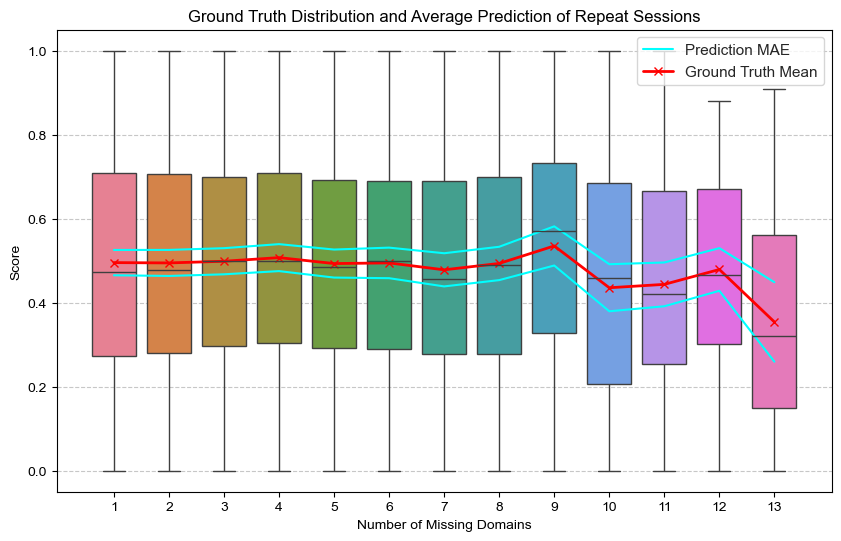

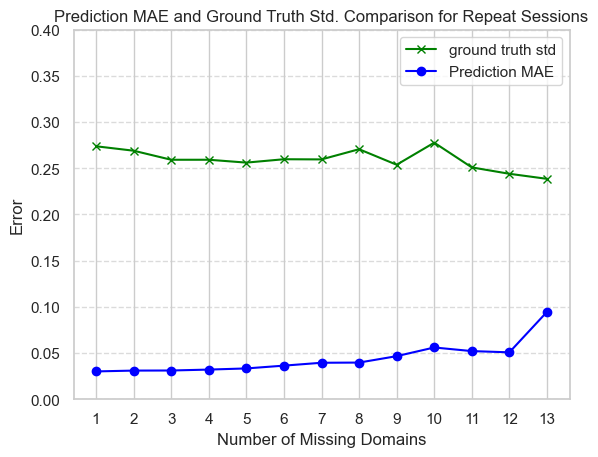

In [42]:
plot_error_by_nan_count_nonzero_only(ground_truth_prediction, ground_truth_test_data_final, metric="mae")  # Use "mse" for Mean Squared Error

## average improvement/score by number of missing domains

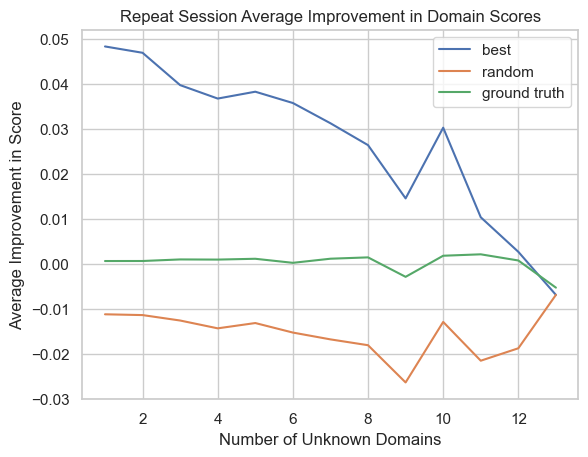

In [43]:
plt.figure()
plt.plot(range(1, 14), nonrepeat_best_avg, label="best")
plt.plot(range(1, 14), nonrepeat_random_avg, label="random")
plt.plot(range(1, 14), nonrepeat_ground_truth_avg, label="ground truth")
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Repeat Session Average Improvement in Domain Scores")
plt.legend()
plt.show()

## violin plot for score

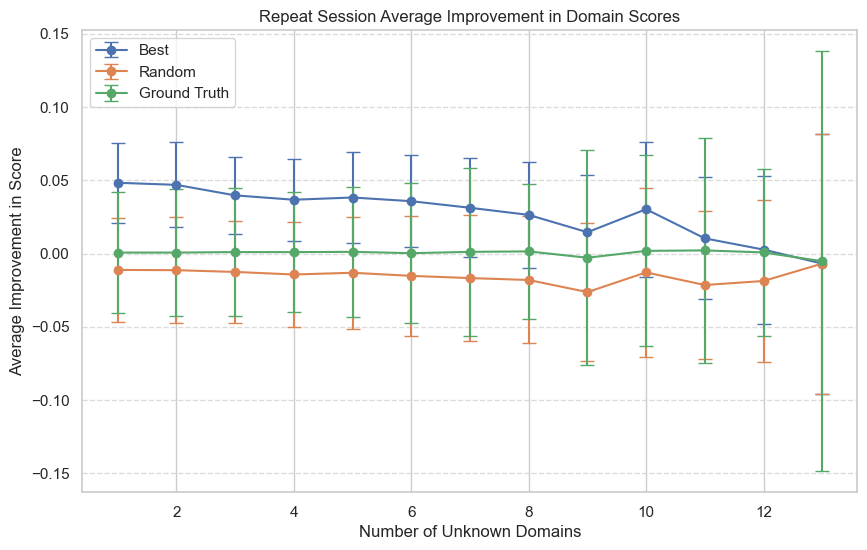

In [44]:
# Define x-axis values (number of unknown domains)
x_values = range(1, 14)

# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(x_values, nonrepeat_best_avg, yerr=nonrepeat_best_std, label="Best", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_random_avg, yerr=nonrepeat_random_std, label="Random", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_ground_truth_avg, yerr=nonrepeat_ground_truth_std, label="Ground Truth", fmt='-o', capsize=5)
# plt.errorbar(x_values, nonrepeat_worst_avg, yerr=nonrepeat_worst_std, label="Worst", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Repeat Session Average Improvement in Domain Scores")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [45]:
def plot_violin_difference(ground_truth_data_df, random_data_df, best_data_df):
    ## set up variables
    ground_truth_dict = dict()
    random_dict = dict()
    best_dict = dict()

    ## go through data to obtain what's needed for plots
    for n in range(1, 14):
        print("========= %d missing" % n)
        ## set the variables for what we are working with
        print("----ground truth----")
        ground_truth_temp = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
        ground_truth_target_matrix = np.nan_to_num(ground_truth_temp[target_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        ground_truth_current_matrix = np.nan_to_num(ground_truth_temp[score_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        print("current ground truth: ", ground_truth_current_matrix)
        print("target ground truth: ", ground_truth_target_matrix)
        ground_truth_improvement = ground_truth_target_matrix - ground_truth_current_matrix
        ground_truth_dict[str(n)] = ground_truth_improvement
        
        print("----random----")
        random_temp = random_test_data_n[n][random_test_data_n[n].repeat == True]
        random_target_matrix = np.nan_to_num(random_temp[target_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        random_current_matrix = np.nan_to_num(random_temp[score_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        print("current random: ", random_current_matrix)
        print("target random: ", random_target_matrix)
        random_improvement = random_target_matrix - random_current_matrix
        random_dict[str(n)] = random_improvement

        print("----best----")
        best_temp = best_test_data_n[n][best_test_data_n[n].repeat == True]
        best_target_matrix = np.nan_to_num(best_temp[target_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        best_current_matrix = np.nan_to_num(best_temp[score_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        print("current best: ", best_current_matrix)
        print("target best: ", best_target_matrix)
        best_improvement = best_target_matrix - best_current_matrix
        best_dict[str(n)] = best_improvement

        ## assert and print statements for debugging
        # assert ground_truth_temp.shape == random_temp.shape and best_temp.shape == ground_truth_temp.shape, "shapes between don't match"

    ## create plot_df
    plot_df_ground_truth = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)
    plot_df_random = pd.concat(map(pd.Series, random_dict.values()), keys=random_dict.keys(), axis=1)
    plot_df_best = pd.concat(map(pd.Series, best_dict.values()), keys=best_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_ground_truth, ax=axes)
    # sns.violinplot(data=plot_df_random, ax=axes)
    # sns.violinplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Improvement")
    plt.title(f"Ground Truth Average Improvement in Score Distribution by Number of Missing domains")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(-0.3, 0.3)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_random, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Improvement")
    plt.title(f"Random Average Improvement in Score Distribution by Number of Missing domains")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Improvement")
    plt.title(f"Best Average Improvement in Score Distribution by Number of Missing domains")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

========= 1 missing
----ground truth----
current ground truth:  [0.081 0.291 0.785 ... 0.032 0.353 0.467]
target ground truth:  [0.081 0.291 0.754 ... 0.032 0.38  0.467]
----random----
current random:  [0.022 0.26  0.784 ... 0.013 1.    0.846]
target random:  [0.0493406  0.24655047 0.7828754  ... 0.06276456 0.9558791  0.8412739 ]
----best----
current best:  [0.    0.18  0.52  ... 0.    0.05  0.333]
target best:  [0.06135438 0.19047785 0.63168788 ... 0.09622678 0.09654476 0.38187853]
========= 2 missing
----ground truth----
current ground truth:  [0.964 0.78  0.935 ... 0.709 0.189 0.013]
target ground truth:  [0.964 0.78  1.    ... 0.673 0.189 0.   ]
----random----
current random:  [0.947 0.26  0.916 ... 0.557 0.43  0.189]
target random:  [0.907323   0.22764292 0.9233975  ... 0.5596292  0.39596465 0.20091493]
----best----
current best:  [0.758 0.37  0.916 ... 0.6   0.    0.013]
target best:  [0.77033204 0.37567633 0.92339748 ... 0.62304085 0.085574   0.09083378]
========= 3 missing
----

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_31217/1372381209.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


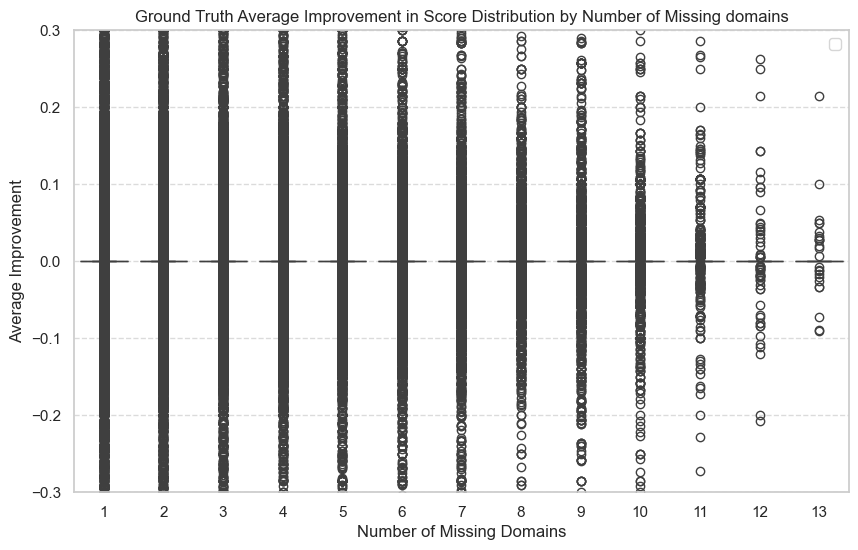

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_31217/1372381209.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


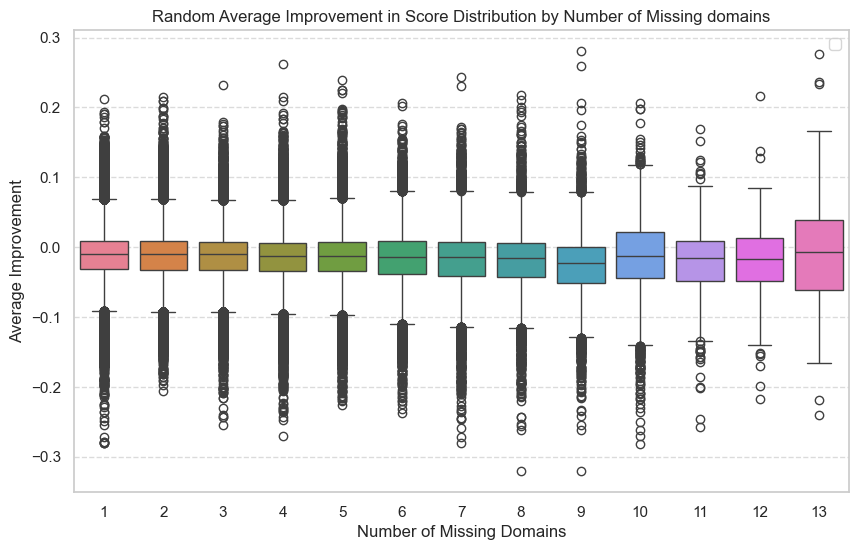

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_31217/1372381209.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


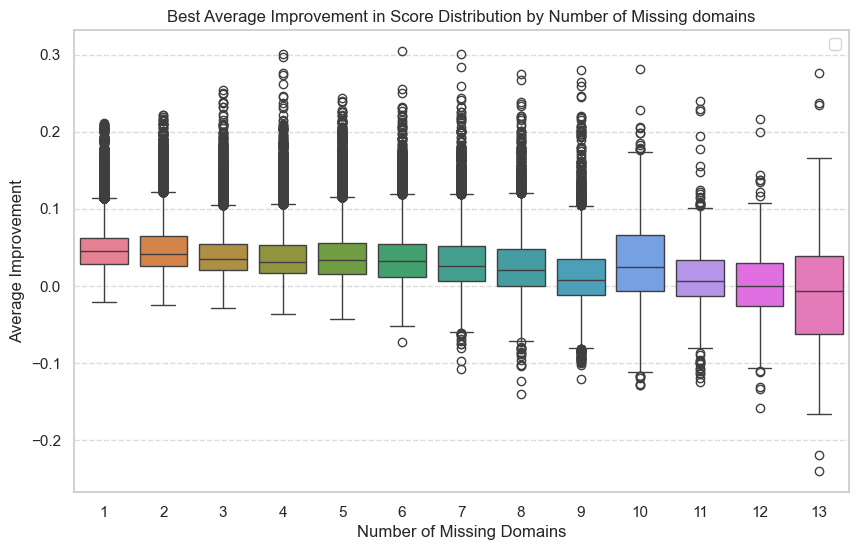

In [46]:
plot_violin_difference(ground_truth_test_data_final, random_test_data_final, best_test_data_final)

# Misc

In [47]:
ids = []

In [48]:
for n in range(1, 14):
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_repeat) != 0:
        ids.append(temp_repeat.index[0])
    if len(temp_nonrepeat) != 0:
        ids.append(temp_nonrepeat.index[0])

In [ ]:
ids

[np.int64(5198989),
 np.int64(4134494),
 np.int64(108777),
 np.int64(4184746),
 np.int64(2051828),
 np.int64(5447081),
 np.int64(4856734),
 np.int64(275940),
 np.int64(3485634),
 np.int64(2213497),
 np.int64(274747),
 np.int64(3888559),
 np.int64(4325322)]

Bad pipe message: %s [b'A"ls\x85N\xa1\xf2"\xd4\xdfV,\'\xb0>A\x8a\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000']
Bad pipe message: %s [b'y0\x9e\xa0\xee4\n\x0eT\xab\x1dM\tG\x99J\x11\xc4']
Bad pipe message: %s [b'\x10\xf8o\xe1\xa9X\xca\n\x06\xab\xdb\x96)\xfa4\t\x7f>\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97']
Bad pipe message: %s [b'\x91\x18Z5Pt;lY\xec\x1aP0\x8f\xf0\xfe&\x86\x00\x01|\x00\x00\x00\x01\x00\